In [6]:
%matplotlib inline
import skimage.color
import skimage.io
import skimage.filters
import numpy

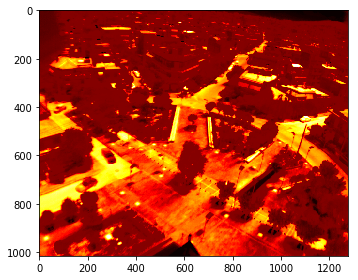

In [3]:
raw = skimage.io.imread("AthenIR.png")
img = skimage.color.rgb2gray(raw)
skimage.io.imshow(img, cmap='hot')

In [ ]:
# -*- coding: utf-8 -*-
"""
Skeleton for exercize on edge operators
"""

def convolve_kernel(image, kernel, normfactor=1.0, edge_value=0.0):
    if kernel.shape != (3, 3):
        raise ValueError("Kernel must have shape 3x3")
    
    out = numpy.ndarray(shape=image.shape)
    height, width  = image.shape
    
    for x in range(0, width):
        for y in range(0, height):
            new_value = 0
            for kx in (-1, 0, 1):
                for ky in (-1, 0, 1):
                    # if trying to access outside image, instead use closest value
                    sx = min(max(x+kx, 0), width-1)
                    sy = min(max(y+ky, 0), height-1)
                    #print(sx, sy)
                    new_value += image[sy][sx] * normfactor
            out[y][x] = new_value
    return out
    
kernels = {
    'sobel_x': numpy.array((
        (-1, 0, -1),
        (-1, 0, -1),
        (-1, 0, -1),
     )),
    'sobel_y': numpy.array((
        (-1, -1, -1),
        (0, 0, 0),
        (-1, -1, -1),
     )),
}
                             
def edge_operator(image, operator):
    """Returns the reusult from one of the edge operators, prewitt, sobel,
    canny eller laplace
    Parameters:
    -----------
    image : np.ndarray
    Image to detect blobs in. If this image is a colour image then
    the last dimension will be the colour value (as RGB values).
    operator : numeric
    1. = sobel filter
    2. = prewitt filter
    3. = canny filter
    4. = laplace filter
    Returns:
    --------
    filtered : np.ndarray(np.uint)
    result image from the edge operator
    """

    kernel_x = kernels['sobel_x']
    kernel_y = kernels['sobel_x']
    
    x = convolve_kernel(image, kernel_x)
    y = convolve_kernel(image, kernel_y)
    filtered = x
    
    # sobel and prewitt are simple edge filters with two 3x3 kernels, one for X, and one for Y direction
    # There is also a modified Sobel with better cofficients (total=32)
    # And extended sobel with 8 kernels, for each 45 degree
    
    # Laplacian (p.139) can be expressed as one 3x3 kernel for both x and y
    
    # Canny (p.133) is more complicated
    # Smooth image with Gaussian filter
    # Calculate x/y gradient vector, local gradient magnitude/orientation
    # Isolate local maxima of gradient magnitude using 'non-maximum supression' along local gradient direction
    # Collect sets of connected edge pixels from local maxima using hysteresis threshold
    
    return filtered


raw = skimage.io.imread("AthenIR.png")
img = skimage.color.rgb2gray(raw)
img = edge_operator(img, 'sobel')
#print(img.shape)
#skimage.io.imshow(raw)

skimage.io.imshow(img, cmap='hot')

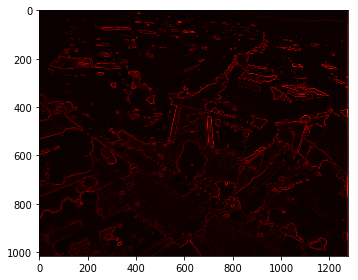

In [5]:
filtered = skimage.filters.sobel(img)
skimage.io.imshow(filtered, cmap='hot')

In [9]:
def sharpen(image, sharpmask):
    """Performs an image sharpening using Laplace filter or unsharpen mask 
    (USM)
    1. = Laplace
    2. = USM
    Returns: sharpened image
    """
    
    # Laplace sharpening done by applying Laplacian filter,
    # then from image subtracting a fraction of it 
    
    # Unsharpen-mask
    # Subtract from input a smoothened image, result is the mask
    # Add the mask to input, weigthed by factor A
    # Smoothening filter is typically a Gaussian filter
    
    return sharpened

describe the resulting images. Which algorithms and with which parameters do you think yielded the best image sharpening in this case 